In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time
import pickle
import matplotlib.cm as cm
import seaborn as sns
from torchvision import transforms

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import sys
import gc
sys.path.append("../../ProtoLearning/")
import data as data
import utils as utils
from models.icsn import iCSN
from models.icsn_disc import iCSN as iCSN_disc
from models.icsn_groups_singledec import iCSN as iCSN_groups_singledec
from models.icsn_groups_muldec import iCSN as iCSN_groups_muldec
#from models.vt import VT as VT
from models.vt_groups_singledec import VT as VT_groups_singledec
from models.vt_groups_muldec import VT as VT_groups_muldec
from models.vt_singledec import VT as VT_singledec

In [17]:
DEVICE_ID = 1
device = torch.device(f"cuda:{DEVICE_ID}" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [18]:
def load_pretrained(model, ckpt):
    model.load_state_dict(ckpt['model'])
    model.proto_dict = ckpt['model_misc']['prototypes']
    model.softmax_temp = ckpt['model_misc']['softmax_temp']
    return model


def plot_single_img(model, imgs, idx):
    model.eval()
    preds, recons = model.forward_single(imgs)

    recons = recons.permute(0, 2, 3, 1).detach().cpu()
    imgs = imgs.permute(0, 2, 3, 1).detach().cpu()
    preds = preds.unsqueeze(dim=0).detach().cpu()
    preds = preds[0, idx]
    preds_as_ids = [torch.argmax(preds[model.attr_positions[i]:model.attr_positions[i+1]]).numpy() for i in range(model.n_groups)]

    # convert to RGB numpy array
    recons_np = recons[idx].squeeze().numpy()
    # convert -1 1 range to 0 255 range for plotting
    recons_np = ((recons_np - recons_np.min())
              * (1 / (recons_np.max() - recons_np.min()) * 255)).astype('uint8')
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))
    ax[0].imshow(imgs[idx])
    ax[0].axis('off')
    ax[0].set_title("Input Img");
    ax[1].imshow(preds.unsqueeze(dim=0), cmap=cm.gray)
    ax[1].axes.yaxis.set_visible(False)
    ax[1].set_title("I believe it has these properties");
#     ax[1].set_xlabel("Attributes");
    ax[2].imshow(recons_np)
    ax[2].axis('off')
    ax[2].set_title("Because it is close to these composed prototypes:");
    plt.show()
    
    return fig, preds_as_ids


### Create a dictionary to convert a label list of individual groups to a single id

In [19]:
convert_multilabel_to_label_id = {}
id = 0
for i in range(4):
    for j in range(4):
        for k in range(2):
            convert_multilabel_to_label_id[f'{i}{j}{k}'] = id
            id+=1

### Get training and validation set containing old and new objects for linear probing

In [20]:
# train data set
train_probing_data_path = f"../../../Data/ECR/train_probing/train_probing_ecr.npy"
train_probing_labels_path = f"../../../Data/ECR/train_probing/train_probing_ecr_labels.pkl"

train_probing_imgs = np.load(train_probing_data_path, allow_pickle=True)
train_probing_imgs = (train_probing_imgs - train_probing_imgs.min()) / (train_probing_imgs.max() - train_probing_imgs.min())

with open(train_probing_labels_path, 'rb') as f:
    labels_dict = pickle.load(f)
    train_probing_labels = labels_dict['labels']
  
train_probing_imgs = torch.tensor(np.moveaxis(train_probing_imgs, (0, 1, 2, 3), (0, 2, 3, 1)))
train_probing_imgs = train_probing_imgs.type('torch.FloatTensor')
train_probing_labels = torch.tensor(train_probing_labels)    

# convert multi label to single label
train_probing_labels = train_probing_labels.int()
# single_train_probing_labels = torch.tensor([convert_multilabel_to_label_id[f'{train_probing_labels[i][0].item()}{train_probing_labels[i][1].item()}{train_probing_labels[i][2].item()}'] for i in range(train_probing_labels.shape[0])])

train_probing_dataset = torch.utils.data.TensorDataset(train_probing_imgs, train_probing_labels)
train_probing_dataloader = torch.utils.data.DataLoader(train_probing_dataset, batch_size=len(train_probing_dataset),
                                                  shuffle=True)

# val data set
val_data_path = f"../../../Data/ECR/val/val_ecr.npy"
val_labels_path = f"../../../Data/ECR/val/val_ecr_labels.pkl"

val_imgs = np.load(val_data_path, allow_pickle=True)
val_imgs = (val_imgs - val_imgs.min()) / (val_imgs.max() - val_imgs.min())

with open(val_labels_path, 'rb') as f:
    labels_dict = pickle.load(f)
    val_labels = labels_dict['labels']
  
val_imgs = torch.tensor(np.moveaxis(val_imgs, (0, 1, 2, 3), (0, 2, 3, 1)))
val_imgs = val_imgs.type('torch.FloatTensor')
val_labels = torch.tensor(val_labels)    

# convert multi label to single label
val_labels = val_labels.int()
# single_val_labels = torch.tensor([convert_multilabel_to_label_id[f'{val_labels[i][0].item()}{val_labels[i][1].item()}{val_labels[i][2].item()}'] for i in range(val_labels.shape[0])])

val_dataset = torch.utils.data.TensorDataset(val_imgs, val_labels)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset),
                                                  shuffle=True)

# get data from loader
train_probing_imgs, train_probing_label_ids = next(iter(train_probing_dataloader))
val_imgs, val_label_ids = next(iter(val_dataloader))

# convert multilabel to single label
train_probing_single_labels = torch.tensor([convert_multilabel_to_label_id[
    f'{train_probing_label_ids[i][0].item()}{train_probing_label_ids[i][1].item()}{train_probing_label_ids[i][2].item()}'] for i in range(train_probing_label_ids.shape[0])])
val_single_labels = torch.tensor([convert_multilabel_to_label_id[
    f'{val_label_ids[i][0].item()}{val_label_ids[i][1].item()}{val_label_ids[i][2].item()}'] for i in range(val_label_ids.shape[0])])

### Variance calculation for Proto-Swap-AE

In [23]:
def compute_code_and_variance(model, imgs, gt_labels_ids, config):
    collect_codes = {}

    try:
        codes, _ = model.forward_single(imgs)
        codes = codes.detach()
    except Exception as e:
        print(e)
        raise NotImplementedError
        _, codes = model.forward(imgs)
        codes = codes.squeeze(dim=2)

    # for every GT attribute collect the codes from each model and data set
    for cat_id in range(0, 3):
        
        for concept_id in range(0, 4):
        
            # find those samples that have the same concept in the specified category identifier
            rel_ids = torch.where(gt_labels_ids.T[cat_id] == concept_id)[0]
            
            # filter out the model code for those samples in the specified category identifier
            try:
                rel_codes = codes[rel_ids, 
                                   config['prototype_cumsum'][cat_id]:config['prototype_cumsum'][cat_id+1]]
            except:
                rel_codes = codes[rel_ids, cat_id]
            
            # store the individual codes
            collect_codes[f"{str(cat_id)}-{str(concept_id)}"] = rel_codes.detach().cpu()

    collect_variance = {}

    sum_variance = 0.

    # iterate over each GT attribute and compute the code variance at the relevant factor id
    for cat_id in range(0, 3):
    
        for concept_id in range(0, 4):
            
            var = torch.sum(torch.var(collect_codes[f"{str(cat_id)}-{str(concept_id)}"], dim=0))

            if not torch.isnan(var):
            
                collect_variance[f"{str(cat_id)}-{str(concept_id)}"] = var
                
                sum_variance += var
                 
    sum_variance /= len(collect_variance.keys())
    
    print(sum_variance)

    return {'codes': codes, 'collect_codes': collect_codes, 
                                  'variances': collect_variance, 'avg_variance': sum_variance}


train_probing_imgs_copy = train_probing_imgs.clone().detach()
val_imgs_copy = val_imgs.clone().detach()


# CSN model (all groups trained simultaneously)
icsn_results_all = {}
icsn_models = [
    "csn0_seed0_protos[6, 6, 6]_2023-02-15_15-50-33",
    "csn1",
    "csn3"
]
for model_id, model_path in enumerate(icsn_models):    
    ckpt_fp = f"../../../results/{model_path}/states/07999.pth"
    print(f"Loading model {ckpt_fp}")
    ckpt = torch.load(ckpt_fp, map_location=device)
    config = ckpt['config']
    config['device'] = device
    config['data_dir'] = '../Data/ECR/'

    icsn_model = iCSN(num_hiddens=64, num_residual_layers=2, num_residual_hiddens=64,
                    n_proto_vecs=config['prototype_vectors'], lin_enc_size=config['lin_enc_size'],
                    proto_dim=config['proto_dim'], softmax_temp=config['temperature'],
                    extra_mlp_dim=config['extra_mlp_dim'],
                    multiheads=config['multiheads'], train_protos=config['train_protos'],
                    device=config['device'])

    icsn_model = icsn_model.to(config['device'])
    train_probing_imgs = train_probing_imgs_copy.clone().detach().to(config['device'])
    val_imgs = val_imgs_copy.clone().detach().to(config['device'])
    icsn_model = load_pretrained(icsn_model, ckpt)
    icsn_model.temperature = 0.000001
    icsn_model.eval();
        
    train_result_dict = compute_code_and_variance(model=icsn_model, imgs=train_probing_imgs, 
                                                  gt_labels_ids=train_probing_label_ids, config=config)
    val_result_dict = compute_code_and_variance(model=icsn_model, imgs=val_imgs, 
                                                  gt_labels_ids=val_label_ids, config=config)

    icsn_results_all[model_id] = {'train': train_result_dict, 'val': val_result_dict}

    del icsn_model
    del train_probing_imgs
    del val_imgs
    with torch.cuda.device(device):
        torch.cuda.empty_cache()


# CSN model single decoder
csn_singledec_results_all = {}
csn_singledec_models = [
    "csn0_singledec",
    "csn1_singledec",
    "csn3_singledec"
]

for model_id, model_path in enumerate(csn_singledec_models):    
    ckpt_fp = f"../../../results/{model_path}/states/07999.pth"
    print(f"Loading model {ckpt_fp}")
    ckpt = torch.load(ckpt_fp, map_location=device)
    config = ckpt['config']
    config['device'] = device
    config['data_dir'] = '../Data/ECR/'

    csn_model = iCSN_groups_singledec(num_hiddens=64, num_residual_layers=2, num_residual_hiddens=64,
                    n_proto_vecs=config['prototype_vectors'], lin_enc_size=config['lin_enc_size'],
                    proto_dim=config['proto_dim'], softmax_temp=config['temperature'],
                    extra_mlp_dim=config['extra_mlp_dim'],
                    multiheads=config['multiheads'], train_protos=config['train_protos'],
                    device=config['device'])

    csn_model = csn_model.to(config['device'])
    train_probing_imgs = train_probing_imgs_copy.clone().detach().to(config['device'])
    val_imgs = val_imgs_copy.clone().detach().to(config['device'])
    csn_model = load_pretrained(csn_model, ckpt)
    csn_model.temperature = 0.000001
    csn_model.eval();
        
    train_result_dict = compute_code_and_variance(model=csn_model, imgs=train_probing_imgs, 
                                                  gt_labels_ids=train_probing_label_ids, config=config)
    val_result_dict = compute_code_and_variance(model=csn_model, imgs=val_imgs, 
                                                  gt_labels_ids=val_label_ids, config=config)

    csn_singledec_results_all[model_id] = {'train': train_result_dict, 'val': val_result_dict}

    del csn_model
    del train_probing_imgs
    del val_imgs
    with torch.cuda.device(device):
        torch.cuda.empty_cache()


        
# CSN model multiple decoders
csn_muldec_results_all = {}
csn_muldec_models = [
    "csn0_muldec",
    "csn1_muldec",
    "csn3_muldec"
]

for model_id, model_path in enumerate(csn_muldec_models):    
    ckpt_fp = f"../../../results/{model_path}/states/07999.pth"
    print(f"Loading model {ckpt_fp}")
    ckpt = torch.load(ckpt_fp, map_location=device)
    config = ckpt['config']
    config['device'] = device
    config['data_dir'] = '../Data/ECR/'

    csn_model = iCSN_groups_muldec(num_hiddens=64, num_residual_layers=2, num_residual_hiddens=64,
                    n_proto_vecs=config['prototype_vectors'], lin_enc_size=config['lin_enc_size'],
                    proto_dim=config['proto_dim'], softmax_temp=config['temperature'],
                    extra_mlp_dim=config['extra_mlp_dim'],
                    multiheads=config['multiheads'], train_protos=config['train_protos'],
                    device=config['device'])

    csn_model = csn_model.to(config['device'])
    train_probing_imgs = train_probing_imgs_copy.clone().detach().to(config['device'])
    val_imgs = val_imgs_copy.clone().detach().to(config['device'])
    csn_model = load_pretrained(csn_model, ckpt)
    csn_model.temperature = 0.000001
    csn_model.eval();
        
    train_result_dict = compute_code_and_variance(model=csn_model, imgs=train_probing_imgs, 
                                                  gt_labels_ids=train_probing_label_ids, config=config)
    val_result_dict = compute_code_and_variance(model=csn_model, imgs=val_imgs, 
                                                  gt_labels_ids=val_label_ids, config=config)

    csn_muldec_results_all[model_id] = {'train': train_result_dict, 'val': val_result_dict}

    del csn_model
    del train_probing_imgs
    del val_imgs
    with torch.cuda.device(device):
        torch.cuda.empty_cache()




        
# CSN model continuous
csn_continuous_results_all = {}
csn_continuous_models = [
    "csn_continous1_seed1_protos[6, 6, 6]_2023-02-17_13-18-50",
    "csn_continous3_seed3_protos[6, 6, 6]_2023-02-17_13-21-37",
    "csn0_continous_seed0_protos[6, 6, 6]_2023-02-15_18-12-01"
]

for model_id, model_path in enumerate(csn_continuous_models):    
    ckpt_fp = f"../../../results/{model_path}/states/07999.pth"
    print(f"Loading model {ckpt_fp}")
    ckpt = torch.load(ckpt_fp, map_location=device)
    config = ckpt['config']
    config['device'] = device
    config['data_dir'] = '../Data/ECR/'

    csn_model = iCSN(num_hiddens=64, num_residual_layers=2, num_residual_hiddens=64,
                    n_proto_vecs=config['prototype_vectors'], lin_enc_size=config['lin_enc_size'],
                    proto_dim=config['proto_dim'], softmax_temp=config['temperature'],
                    extra_mlp_dim=config['extra_mlp_dim'],
                    multiheads=config['multiheads'], train_protos=config['train_protos'],
                    device=config['device'])

    csn_model = csn_model.to(config['device'])
    train_probing_imgs = train_probing_imgs_copy.clone().detach().to(config['device'])
    val_imgs = val_imgs_copy.clone().detach().to(config['device'])
    csn_model = load_pretrained(csn_model, ckpt)
    csn_model.temperature = 0.000001
    csn_model.eval();
        
    train_result_dict = compute_code_and_variance(model=csn_model, imgs=train_probing_imgs, 
                                                  gt_labels_ids=train_probing_label_ids, config=config)
    val_result_dict = compute_code_and_variance(model=csn_model, imgs=val_imgs, 
                                                  gt_labels_ids=val_label_ids, config=config)

    csn_continuous_results_all[model_id] = {'train': train_result_dict, 'val': val_result_dict}

    del csn_model
    del train_probing_imgs
    del val_imgs
    with torch.cuda.device(device):
        torch.cuda.empty_cache()


# CSN model unsupervised
csn_unsup_results_all = {}
csn_unsup_models = [
    "csn_unsupervised_continuous0_seed0_protos[6, 6, 6]_2023-02-15_18-12-36",
    "csn_unsupervised_continuous1_seed1_protos[6, 6, 6]_2023-02-17_13-15-08",
    "csn_unsupervised_continuous3_seed3_protos[6, 6, 6]_2023-02-17_13-16-32"
]

for model_id, model_path in enumerate(csn_unsup_models):    
    ckpt_fp = f"../../../results/{model_path}/states/07999.pth"
    print(f"Loading model {ckpt_fp}")
    ckpt = torch.load(ckpt_fp, map_location=device)
    config = ckpt['config']
    config['device'] = device
    config['data_dir'] = '../Data/ECR/'

    csn_model = iCSN(num_hiddens=64, num_residual_layers=2, num_residual_hiddens=64,
                    n_proto_vecs=config['prototype_vectors'], lin_enc_size=config['lin_enc_size'],
                    proto_dim=config['proto_dim'], softmax_temp=config['temperature'],
                    extra_mlp_dim=config['extra_mlp_dim'],
                    multiheads=config['multiheads'], train_protos=config['train_protos'],
                    device=config['device'])

    csn_model = csn_model.to(config['device'])
    train_probing_imgs = train_probing_imgs_copy.clone().detach().to(config['device'])
    val_imgs = val_imgs_copy.clone().detach().to(config['device'])
    csn_model = load_pretrained(csn_model, ckpt)
    csn_model.temperature = 0.000001
    csn_model.eval();
        
    train_result_dict = compute_code_and_variance(model=csn_model, imgs=train_probing_imgs, 
                                                  gt_labels_ids=train_probing_label_ids, config=config)
    val_result_dict = compute_code_and_variance(model=csn_model, imgs=val_imgs, 
                                                  gt_labels_ids=val_label_ids, config=config)

    csn_unsup_results_all[model_id] = {'train': train_result_dict, 'val': val_result_dict}

    del csn_model
    del train_probing_imgs
    del val_imgs
    with torch.cuda.device(device):
        torch.cuda.empty_cache()


# CSN model discriminator
csn_disc_results_all = {}
csn_disc_models = [
    "icsn_disc0",
    "icsn_disc1",
    "icsn_disc3",
]

for model_id, model_path in enumerate(csn_disc_models):    
    ckpt_fp = f"../../../results/{model_path}/states/07999.pth"
    print(f"Loading model {ckpt_fp}")
    ckpt = torch.load(ckpt_fp, map_location=device)
    config = ckpt['config']
    config['device'] = device
    config['data_dir'] = '../Data/ECR/'

    csn_model = iCSN_disc(num_hiddens=64, num_residual_layers=2, num_residual_hiddens=64,
                    n_proto_vecs=config['prototype_vectors'], lin_enc_size=config['lin_enc_size'],
                    proto_dim=config['proto_dim'], softmax_temp=config['temperature'],
                    extra_mlp_dim=config['extra_mlp_dim'],
                    multiheads=config['multiheads'], train_protos=config['train_protos'],
                    device=config['device'])

    csn_model = csn_model.to(config['device'])
    train_probing_imgs = train_probing_imgs_copy.clone().detach().to(config['device'])
    val_imgs = val_imgs_copy.clone().detach().to(config['device'])
    csn_model = load_pretrained(csn_model, ckpt)
    csn_model.temperature = 0.000001
    csn_model.eval();
        
    train_result_dict = compute_code_and_variance(model=csn_model, imgs=train_probing_imgs, 
                                                  gt_labels_ids=train_probing_label_ids, config=config)
    val_result_dict = compute_code_and_variance(model=csn_model, imgs=val_imgs, 
                                                  gt_labels_ids=val_label_ids, config=config)

    csn_disc_results_all[model_id] = {'train': train_result_dict, 'val': val_result_dict}

    del csn_model
    del train_probing_imgs
    del val_imgs
    with torch.cuda.device(device):
        torch.cuda.empty_cache()



# VT groups model
vt_groups_models = [
    "vt_groups_seed0_protos[6, 6, 6]_2023-02-10_09-16-18",
    "vt_groups_seed1_protos[6, 6, 6]_2023-02-11_17-09-22",
    "vt_groups_seed3"
]
vt_groups_results_all = {}
for model_id, model_path in enumerate(vt_groups_models):
    ckpt_fp = f"../../../results/{model_path}/states/07999.pth"
    print(f"Loading model {ckpt_fp}")
    ckpt = torch.load(ckpt_fp, map_location=device)
    config = ckpt['config']
    config['device'] = device
    config['data_dir'] = '../Data/ECR/'

    vt_groups_model = VT_groups_singledec(num_hiddens=64, num_residual_layers=2, num_residual_hiddens=64,
                    n_proto_vecs=config['prototype_vectors'], lin_enc_size=config['lin_enc_size'],
                    proto_dim=config['proto_dim'], softmax_temp=config['temperature'],
                    extra_mlp_dim=config['extra_mlp_dim'],
                    multiheads=config['multiheads'], train_protos=config['train_protos'],
                    device=config['device'])

    vt_groups_model = vt_groups_model.to(config['device'])
    train_probing_imgs = train_probing_imgs_copy.clone().detach().to(config['device'])
    val_imgs = val_imgs_copy.clone().detach().to(config['device'])
    vt_groups_model.load_state_dict(ckpt['model'])
    vt_groups_model.eval();

    train_result_dict = compute_code_and_variance(model=vt_groups_model, imgs=train_probing_imgs, 
                                                  gt_labels_ids=train_probing_label_ids, config=config)
    val_result_dict = compute_code_and_variance(model=vt_groups_model, imgs=val_imgs, 
                                                  gt_labels_ids=val_label_ids, config=config)

    vt_groups_results_all[model_id] = {'train': train_result_dict, 'val': val_result_dict}

    del vt_groups_model
    del train_probing_imgs
    del val_imgs
    with torch.cuda.device(device):
        torch.cuda.empty_cache()


# VT single decoder model
vt_singledec_models = [
    "vt_singledec0_continuous_seed0_protos[6, 6, 6]_2023-02-15_18-09-59",
    "vt_singledec1_continuous_seed1_protos[6, 6, 6]_2023-02-20_15-55-04",
    "vt_singledec3_continuous_seed3_protos[6, 6, 6]_2023-02-20_15-56-21"
]
vt_singledec_results_all = {}
for model_id, model_path in enumerate(vt_singledec_models):
    ckpt_fp = f"../../../results/{model_path}/states/07999.pth"
    print(f"Loading model {ckpt_fp}")
    ckpt = torch.load(ckpt_fp, map_location=device)
    config = ckpt['config']
    config['device'] = device
    config['data_dir'] = '../Data/ECR/'

    vt_groups_model = VT_singledec(num_hiddens=64, num_residual_layers=2, num_residual_hiddens=64,
                    n_proto_vecs=config['prototype_vectors'], lin_enc_size=config['lin_enc_size'],
                    proto_dim=config['proto_dim'], softmax_temp=config['temperature'],
                    extra_mlp_dim=config['extra_mlp_dim'],
                    multiheads=config['multiheads'], train_protos=config['train_protos'],
                    device=config['device'])

    vt_groups_model = vt_groups_model.to(config['device'])
    train_probing_imgs = train_probing_imgs_copy.clone().detach().to(config['device'])
    val_imgs = val_imgs_copy.clone().detach().to(config['device'])
    vt_groups_model.load_state_dict(ckpt['model'])
    vt_groups_model.eval();

    train_result_dict = compute_code_and_variance(model=vt_groups_model, imgs=train_probing_imgs, 
                                                  gt_labels_ids=train_probing_label_ids, config=config)
    val_result_dict = compute_code_and_variance(model=vt_groups_model, imgs=val_imgs, 
                                                  gt_labels_ids=val_label_ids, config=config)

    vt_singledec_results_all[model_id] = {'train': train_result_dict, 'val': val_result_dict}

    del vt_groups_model
    del train_probing_imgs
    del val_imgs
    with torch.cuda.device(device):
        torch.cuda.empty_cache()


# VT muldec discriminator model
vt_muldec_models = [
    "vt_muldec_seed0_protos[6, 6, 6]_2023-02-10_09-00-28",
    "vt_muldec_disc_seed1_protos[6, 6, 6]_2023-02-11_17-07-51",
    "vt_muldec_disc3"
]
vt_muldec_results_all = {}
for model_id, model_path in enumerate(vt_muldec_models):
    ckpt_fp = f"../../../results/{model_path}/states/07999.pth"
    print(f"Loading model {ckpt_fp}")
    ckpt = torch.load(ckpt_fp, map_location=device)
    config = ckpt['config']
    config['device'] = device
    config['data_dir'] = '../Data/ECR/'

    vt_muldec_model = VT_groups_muldec(num_hiddens=64, num_residual_layers=2, num_residual_hiddens=64,
                    n_proto_vecs=config['prototype_vectors'], lin_enc_size=config['lin_enc_size'],
                    proto_dim=config['proto_dim'], softmax_temp=config['temperature'],
                    extra_mlp_dim=config['extra_mlp_dim'],
                    multiheads=config['multiheads'], train_protos=config['train_protos'],
                    device=config['device'])

    vt_muldec_model = vt_muldec_model.to(config['device'])
    train_probing_imgs = train_probing_imgs_copy.clone().detach().to(config['device'])
    val_imgs = val_imgs_copy.clone().detach().to(config['device'])
    vt_muldec_model.load_state_dict(ckpt['model'])
    vt_muldec_model.eval();

    train_result_dict = compute_code_and_variance(model=vt_muldec_model, imgs=train_probing_imgs, 
                                                  gt_labels_ids=train_probing_label_ids, config=config)
    val_result_dict = compute_code_and_variance(model=vt_muldec_model, imgs=val_imgs, 
                                                  gt_labels_ids=val_label_ids, config=config)

    vt_muldec_results_all[model_id] = {'train': train_result_dict, 'val': val_result_dict}
       
    del vt_muldec_model
    del train_probing_imgs
    del val_imgs
    with torch.cuda.device(device):
        torch.cuda.empty_cache()
        
        
        
# VT discriminator model
vt_disc_models = [
    "vt_disc0",
    "vt_disc1",
    "vt_disc3",
]
vt_disc_results_all = {}
for model_id, model_path in enumerate(vt_disc_models):
    ckpt_fp = f"../../../results/{model_path}/states/07999.pth"
    print(f"Loading model {ckpt_fp}")
    ckpt = torch.load(ckpt_fp, map_location=device)
    config = ckpt['config']
    config['device'] = device
    config['data_dir'] = '../Data/ECR/'

    vt_disc_model = VT_singledec(num_hiddens=64, num_residual_layers=2, num_residual_hiddens=64,
                    n_proto_vecs=config['prototype_vectors'], lin_enc_size=config['lin_enc_size'],
                    proto_dim=config['proto_dim'], softmax_temp=config['temperature'],
                    extra_mlp_dim=config['extra_mlp_dim'],
                    multiheads=config['multiheads'], train_protos=config['train_protos'],
                    device=config['device'])

    vt_disc_model = vt_disc_model.to(config['device'])
    train_probing_imgs = train_probing_imgs_copy.clone().detach().to(config['device'])
    val_imgs = val_imgs_copy.clone().detach().to(config['device'])
    vt_disc_model.load_state_dict(ckpt['model'])
    vt_disc_model.eval();

    train_result_dict = compute_code_and_variance(model=vt_disc_model, imgs=train_probing_imgs, 
                                                  gt_labels_ids=train_probing_label_ids, config=config)
    val_result_dict = compute_code_and_variance(model=vt_disc_model, imgs=val_imgs, 
                                                  gt_labels_ids=val_label_ids, config=config)

    vt_disc_results_all[model_id] = {'train': train_result_dict, 'val': val_result_dict}
       
    del vt_disc_model
    del train_probing_imgs
    del val_imgs
    with torch.cuda.device(device):
        torch.cuda.empty_cache()

Loading model ../../../results/csn0_seed0_protos[6, 6, 6]_2023-02-15_15-50-33/states/07999.pth


/home/ml-mlang/.local/lib/python3.8/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


tensor(0.2317)
tensor(0.2309)
Loading model ../../../results/csn1/states/07999.pth
tensor(0.1167)
tensor(0.1189)
Loading model ../../../results/csn3/states/07999.pth
tensor(0.2733)
tensor(0.2647)
Loading model ../../../results/csn0_singledec/states/07999.pth
tensor(0.0076)
tensor(0.0097)
Loading model ../../../results/csn1_singledec/states/07999.pth
tensor(0.)
tensor(0.)
Loading model ../../../results/csn3_singledec/states/07999.pth
tensor(0.)
tensor(0.)
Loading model ../../../results/csn0_muldec/states/07999.pth
tensor(0.)
tensor(0.)
Loading model ../../../results/csn1_muldec/states/07999.pth
tensor(0.)
tensor(0.)
Loading model ../../../results/csn3_muldec/states/07999.pth
tensor(0.)
tensor(0.)
Loading model ../../../results/csn_continous1_seed1_protos[6, 6, 6]_2023-02-17_13-18-50/states/07999.pth
tensor(0.3183)
tensor(0.3191)
Loading model ../../../results/csn_continous3_seed3_protos[6, 6, 6]_2023-02-17_13-21-37/states/07999.pth
tensor(0.1088)
tensor(0.1029)
Loading model ../../../re

In [24]:
def fit_and_predict_lr_dt(results_dict, gt_single_labels_val, model_seed_id, verbose=0):

    codes_train = results_dict[model_seed_id]['train']['codes']
    codes_val = results_dict[model_seed_id]['val']['codes']

    # decision tree
    clf_dt = DecisionTreeClassifier(random_state=21, max_depth=8)
    clf_dt.fit(codes_train.detach().cpu().numpy(), train_probing_single_labels.numpy())

    # Perform logistic regression
    clf_lr = LogisticRegression(random_state=0, C=0.316, max_iter=1000)
    clf_lr.fit(codes_train.detach().cpu().numpy(), train_probing_single_labels.numpy())

    # Evaluate using the classifiers
    predictions_dt = clf_dt.predict(codes_val.detach().cpu().numpy())
    predictions_lr = clf_lr.predict(codes_val.detach().cpu().numpy())

    accuracy_dt = np.mean((gt_single_labels_val.numpy() == predictions_dt).astype(float)) * 100.
    accuracy_lr = np.mean((gt_single_labels_val.numpy() == predictions_lr).astype(float)) * 100.

    if verbose > 0:
        print(f"\nSeed {model_seed_id} Val accuracy DT codes = {accuracy_dt:.3f}")
        print(f"Seed {model_seed_id} Val accuracy LR codes = {accuracy_lr:.3f}")
    return accuracy_dt, accuracy_lr

print('------------------------------------------------------')
print('CSN')
acc_icsn_dt = []
acc_icsn_lr = []
code_vars_icsn_val = []
for model_id in range(len(icsn_results_all)): 
#for seed_id in [0, 1, 3, 13, 21]:
    accuracy_dt, accuracy_lr = fit_and_predict_lr_dt(results_dict=icsn_results_all, 
                                                     gt_single_labels_val=val_single_labels, model_seed_id=model_id)
    acc_icsn_dt.append(accuracy_dt)
    acc_icsn_lr.append(accuracy_lr)

    code_vars_icsn_val.append(icsn_results_all[model_id]['val']['avg_variance'])

print('------------------------------------------------------')
print('CSN single decoder')
acc_csn_singledec_dt = []
acc_csn_singledec_lr = []
code_vars_csn_singledec_val = []
for model_id in range(len(csn_singledec_results_all)): 
    
    accuracy_dt, accuracy_lr = fit_and_predict_lr_dt(results_dict=csn_singledec_results_all, 
                                                     gt_single_labels_val=val_single_labels, model_seed_id=model_id)
    acc_csn_singledec_dt.append(accuracy_dt)
    acc_csn_singledec_lr.append(accuracy_lr)
    
    code_vars_csn_singledec_val.append(csn_singledec_results_all[model_id]['val']['avg_variance'])

print('------------------------------------------------------')
print('CSN multiple decoders')
acc_csn_muldec_dt = []
acc_csn_muldec_lr = []
code_vars_csn_muldec_val = []
for model_id in range(len(csn_muldec_results_all)): 
    
    accuracy_dt, accuracy_lr = fit_and_predict_lr_dt(results_dict=csn_muldec_results_all, 
                                                     gt_single_labels_val=val_single_labels, model_seed_id=model_id)
    acc_csn_muldec_dt.append(accuracy_dt)
    acc_csn_muldec_lr.append(accuracy_lr)
    
    code_vars_csn_muldec_val.append(csn_muldec_results_all[model_id]['val']['avg_variance'])

print('------------------------------------------------------')
print('CSN continuous')
acc_csn_continuous_dt = []
acc_csn_continuous_lr = []
code_vars_csn_continuous_val = []
for model_id in range(len(csn_continuous_results_all)): 
    
    accuracy_dt, accuracy_lr = fit_and_predict_lr_dt(results_dict=csn_continuous_results_all, 
                                                     gt_single_labels_val=val_single_labels, model_seed_id=model_id)
    acc_csn_continuous_dt.append(accuracy_dt)
    acc_csn_continuous_lr.append(accuracy_lr)
    
    code_vars_csn_continuous_val.append(csn_continuous_results_all[model_id]['val']['avg_variance'])

print('------------------------------------------------------')

print('CSN unsupervised')
acc_csn_unsup_dt = []
acc_csn_unsup_lr = []
code_vars_csn_unsup_val = []
for model_id in range(len(csn_unsup_results_all)): 
    
    accuracy_dt, accuracy_lr = fit_and_predict_lr_dt(results_dict=csn_unsup_results_all, 
                                                     gt_single_labels_val=val_single_labels, model_seed_id=model_id)
    acc_csn_unsup_dt.append(accuracy_dt)
    acc_csn_unsup_lr.append(accuracy_lr)
    
    code_vars_csn_unsup_val.append(csn_unsup_results_all[model_id]['val']['avg_variance'])

print('------------------------------------------------------')

print('CSN discriminator')
acc_csn_disc_dt = []
acc_csn_disc_lr = []
code_vars_csn_disc_val = []
for model_id in range(len(csn_disc_results_all)): 
    
    accuracy_dt, accuracy_lr = fit_and_predict_lr_dt(results_dict=csn_disc_results_all, 
                                                     gt_single_labels_val=val_single_labels, model_seed_id=model_id)
    acc_csn_disc_dt.append(accuracy_dt)
    acc_csn_disc_lr.append(accuracy_lr)
    
    code_vars_csn_disc_val.append(csn_disc_results_all[model_id]['val']['avg_variance'])

print('------------------------------------------------------')
print('VT groups')
acc_vt_groups_dt = []
acc_vt_groups_lr = []
code_vars_vt_groups_val = []
for model_id in range(len(vt_groups_results_all)): 
    
    accuracy_dt, accuracy_lr = fit_and_predict_lr_dt(results_dict=vt_groups_results_all, 
                                                     gt_single_labels_val=val_single_labels, model_seed_id=model_id)
    acc_vt_groups_dt.append(accuracy_dt)
    acc_vt_groups_lr.append(accuracy_lr)
    
    code_vars_vt_groups_val.append(vt_groups_results_all[model_id]['val']['avg_variance'])

print('------------------------------------------------------')
print('VT single decoder')
acc_vt_singledec_dt = []
acc_vt_singledec_lr = []
code_vars_vt_singledec_val = []
for model_id in range(len(vt_singledec_results_all)): 
    
    accuracy_dt, accuracy_lr = fit_and_predict_lr_dt(results_dict=vt_singledec_results_all, 
                                                     gt_single_labels_val=val_single_labels, model_seed_id=model_id)
    acc_vt_singledec_dt.append(accuracy_dt)
    acc_vt_singledec_lr.append(accuracy_lr)
    
    code_vars_vt_singledec_val.append(vt_singledec_results_all[model_id]['val']['avg_variance'])

print('------------------------------------------------------')
print('VT muldec')
acc_vt_muldec_dt = []
acc_vt_muldec_lr = []
code_vars_vt_muldec_val = []
for model_id in range(len(vt_muldec_results_all)): 
    
    accuracy_dt, accuracy_lr = fit_and_predict_lr_dt(results_dict=vt_muldec_results_all, 
                                                     gt_single_labels_val=val_single_labels, model_seed_id=model_id)
    acc_vt_muldec_dt.append(accuracy_dt)
    acc_vt_muldec_lr.append(accuracy_lr)
    
    code_vars_vt_muldec_val.append(vt_muldec_results_all[model_id]['val']['avg_variance'])

print('------------------------------------------------------')
print('VT disc')
acc_vt_disc_dt = []
acc_vt_disc_lr = []
code_vars_vt_disc_val = []
for model_id in range(len(vt_disc_results_all)): 
    
    accuracy_dt, accuracy_lr = fit_and_predict_lr_dt(results_dict=vt_disc_results_all, 
                                                     gt_single_labels_val=val_single_labels, model_seed_id=model_id)
    acc_vt_disc_dt.append(accuracy_dt)
    acc_vt_disc_lr.append(accuracy_lr)
    
    code_vars_vt_disc_val.append(vt_disc_results_all[model_id]['val']['avg_variance'])



print('------------------------------------------------------')
print('------------------------Mean--------------------------')
print('------------------------------------------------------')
print(f"Mean acc. CSN\nDT: {np.mean(acc_icsn_dt)} {np.std(acc_icsn_dt)}"+
      f"\nLR:  {np.mean(acc_icsn_lr)} {np.std(acc_icsn_lr)}\n")
print(f"Mean acc. CSN single decoder\nDT: {np.mean(acc_csn_singledec_dt)} {np.std(acc_csn_singledec_dt)}"+
      f"\nLR:  {np.mean(acc_csn_singledec_lr)} {np.std(acc_csn_singledec_lr)}\n")
print(f"Mean acc. CSN multiple decoders\nDT: {np.mean(acc_csn_muldec_dt)} {np.std(acc_csn_muldec_dt)}"+
      f"\nLR:  {np.mean(acc_csn_muldec_lr)} {np.std(acc_csn_muldec_lr)}\n")
print(f"Mean acc. CSN continuous\nDT: {np.mean(acc_csn_continuous_dt)} {np.std(acc_csn_continuous_dt)}"+
      f"\nLR:  {np.mean(acc_csn_continuous_lr)} {np.std(acc_csn_continuous_lr)}\n")
print(f"Mean acc. CSN unsupervised\nDT: {np.mean(acc_csn_unsup_dt)} {np.std(acc_csn_unsup_dt)}"+
      f"\nLR:  {np.mean(acc_csn_unsup_lr)} {np.std(acc_csn_unsup_lr)}\n")
print(f"Mean acc. CSN discriminator\nDT: {np.mean(acc_csn_disc_dt)} {np.std(acc_csn_disc_dt)}"+
      f"\nLR:  {np.mean(acc_csn_disc_lr)} {np.std(acc_csn_disc_lr)}\n")

print(f"Mean acc. VT groups\nDT: {np.mean(acc_vt_groups_dt)} {np.std(acc_vt_groups_dt)}"+
      f"\nLR:  {np.mean(acc_vt_groups_lr)} {np.std(acc_vt_groups_lr)}\n")
print(f"Mean acc. VT single decoder\nDT: {np.mean(acc_vt_singledec_dt)} {np.std(acc_vt_singledec_dt)}"+
      f"\nLR:  {np.mean(acc_vt_singledec_lr)} {np.std(acc_vt_singledec_lr)}\n")
print(f"Mean acc. VT muldec\nDT: {np.mean(acc_vt_muldec_dt)} {np.std(acc_vt_muldec_dt)}"+
      f"\nLR:  {np.mean(acc_vt_muldec_lr)} {np.std(acc_vt_muldec_lr)}\n")
print(f"Mean acc. VT disc\nDT: {np.mean(acc_vt_disc_dt)} {np.std(acc_vt_disc_dt)}"+
      f"\nLR:  {np.mean(acc_vt_disc_lr)} {np.std(acc_vt_disc_lr)}\n")

------------------------------------------------------
CSN
------------------------------------------------------
CSN single decoder
------------------------------------------------------
CSN multiple decoders
------------------------------------------------------
CSN continuous
------------------------------------------------------
CSN unsupervised
------------------------------------------------------
CSN discriminator
------------------------------------------------------
VT groups
------------------------------------------------------
VT single decoder
------------------------------------------------------
VT muldec
------------------------------------------------------
VT disc
------------------------------------------------------
------------------------Mean--------------------------
------------------------------------------------------
Mean acc. CSN
DT: 34.28333333333333 8.784487590191146
LR:  34.36666666666667 8.779932928116379

Mean acc. CSN single decoder
DT: 7.95 1.48492424

In [25]:
import pandas as pd
results = pd.DataFrame({"model": "CSN", "Decision Tree": [f"{np.mean(acc_icsn_dt):.2f} $\pm$ {np.std(acc_csn_singledec_dt):.2f}"], "Logistic Regression": [f"{np.mean(acc_icsn_lr):.2f} $\pm$ {np.std(acc_icsn_lr):.2f}"]})

results = pd.concat([results, pd.DataFrame({"model": "CSN w/ single decoder", "Decision Tree": [f"{np.mean(acc_csn_singledec_dt):.2f} $\pm$ {np.std(acc_csn_singledec_dt):.2f}"], "Logistic Regression": [f"{np.mean(acc_csn_singledec_lr):.2f} $\pm$ {np.std(acc_csn_singledec_lr):.2f}"]})], ignore_index=True)
results = pd.concat([results, pd.DataFrame({"model": "CSN w/ multiple decoders", "Decision Tree": [f"{np.mean(acc_csn_muldec_dt):.2f} $\pm$ {np.std(acc_csn_muldec_dt):.2f}"], "Logistic Regression": [f"{np.mean(acc_csn_muldec_lr):.2f}$\pm$ {np.std(acc_csn_muldec_lr):.2f}"]})], ignore_index=True)
results = pd.concat([results, pd.DataFrame({"model": "CSN w/ continuous softmax temperature", "Decision Tree": [f"{np.mean(acc_csn_continuous_dt):.2f} $\pm$ {np.std(acc_csn_continuous_dt):.2f}"], "Logistic Regression": [f"{np.mean(acc_csn_continuous_lr):.2f} $\pm$ {np.std(acc_csn_continuous_lr):.2f}"]})], ignore_index=True)
results = pd.concat([results, pd.DataFrame({"model": "CSN w/ unsupervised training", "Decision Tree": [f"{np.mean(acc_csn_unsup_dt):.2f} $\pm$ {np.std(acc_csn_unsup_dt):.2f}"], "Logistic Regression": [f"{np.mean(acc_csn_unsup_lr):.2f} $\pm$ {np.std(acc_csn_unsup_lr):.2f}"]})], ignore_index=True)
results = pd.concat([results, pd.DataFrame({"model": "CSN w/ discriminator", "Decision Tree": [f"{np.mean(acc_csn_disc_dt):.2f} $\pm$ {np.std(acc_csn_disc_dt):.2f}"], "Logistic Regression": [f"{np.mean(acc_csn_disc_lr):.2f} $\pm$ {np.std(acc_csn_disc_lr):.2f}"]})], ignore_index=True)

results = pd.concat([results, pd.DataFrame({"model": "ViT w/ single decoder", "Decision Tree": [f"{np.mean(acc_vt_groups_dt):.2f} $\pm$ {np.std(acc_vt_groups_dt):.2f}"], "Logistic Regression": [f"{np.mean(acc_vt_groups_lr):.2f} $\pm$ {np.std(acc_vt_groups_lr):.2f}"]})], ignore_index=True)
results = pd.concat([results, pd.DataFrame({"model": "ViT w/ discriminator, single decoder", "Decision Tree": [f"{np.mean(acc_vt_singledec_dt):.2f} $\pm$ {np.std(acc_vt_singledec_dt):.2f}"], "Logistic Regression": [f"{np.mean(acc_vt_singledec_lr):.2f} $\pm$ {np.std(acc_vt_singledec_lr):.2f}"]})], ignore_index=True)
results = pd.concat([results, pd.DataFrame({"model": "ViT w/ discriminator, multiple decoders", "Decision Tree": [f"{np.mean(acc_vt_muldec_dt):.2f} $\pm$ {np.std(acc_vt_muldec_dt):.2f}"], "Logistic Regression": [f"{np.mean(acc_vt_muldec_lr):.2f} $\pm$ {np.std(acc_vt_muldec_lr):.2f}"]})], ignore_index=True)
results = pd.concat([results, pd.DataFrame({"model": "ViT w/ discriminator, sim. training", "Decision Tree": [f"{np.mean(acc_vt_disc_dt):.2f} $\pm$ {np.std(acc_vt_disc_dt):.2f}"], "Logistic Regression": [f"{np.mean(acc_vt_disc_lr):.2f} $\pm$ {np.std(acc_vt_disc_lr):.2f}"]})], ignore_index=True)

results

,model,Decision Tree,Logistic Regression
0,CSN,34.28 $\pm$ 1.48,34.37 $\pm$ 8.78
1,CSN w/ single decoder,7.95 $\pm$ 1.48,8.00 $\pm$ 1.56
2,CSN w/ multiple decoders,6.75 $\pm$ 2.68,6.75$\pm$ 2.68
3,CSN w/ continuous softmax temperature,62.83 $\pm$ 27.71,63.03 $\pm$ 27.45
4,CSN w/ unsupervised training,41.63 $\pm$ 4.72,41.67 $\pm$ 4.69
5,CSN w/ discriminator,30.40 $\pm$ 6.45,29.82 $\pm$ 6.24
6,ViT w/ single decoder,60.62 $\pm$ 35.37,3.40 $\pm$ 0.00
7,"ViT w/ discriminator, single decoder",54.03 $\pm$ 12.12,3.40 $\pm$ 0.00
8,"ViT w/ discriminator, multiple decoders",87.38 $\pm$ 5.11,4.38 $\pm$ 1.39
9,"ViT w/ discriminator, sim. training",41.62 $\pm$ 4.76,3.40 $\pm$ 0.00


In [26]:
print(results.to_latex(escape=False))

\begin{tabular}{llll}
\toprule
{} &                                    model &      Decision Tree & Logistic Regression \\
\midrule
0 &                                      CSN &   34.28 $\pm$ 1.48 &    34.37 $\pm$ 8.78 \\
1 &                    CSN w/ single decoder &    7.95 $\pm$ 1.48 &     8.00 $\pm$ 1.56 \\
2 &                 CSN w/ multiple decoders &    6.75 $\pm$ 2.68 &      6.75$\pm$ 2.68 \\
3 &    CSN w/ continuous softmax temperature &  62.83 $\pm$ 27.71 &   63.03 $\pm$ 27.45 \\
4 &             CSN w/ unsupervised training &   41.63 $\pm$ 4.72 &    41.67 $\pm$ 4.69 \\
5 &                     CSN w/ discriminator &   30.40 $\pm$ 6.45 &    29.82 $\pm$ 6.24 \\
6 &                    ViT w/ single decoder &  60.62 $\pm$ 35.37 &     3.40 $\pm$ 0.00 \\
7 &     ViT w/ discriminator, single decoder &  54.03 $\pm$ 12.12 &     3.40 $\pm$ 0.00 \\
8 &  ViT w/ discriminator, multiple decoders &   87.38 $\pm$ 5.11 &     4.38 $\pm$ 1.39 \\
9 &      ViT w/ discriminator, sim. training &   

/tmp/ipykernel_3181568/1557872965.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results.to_latex(escape=False))


### Plot code variance

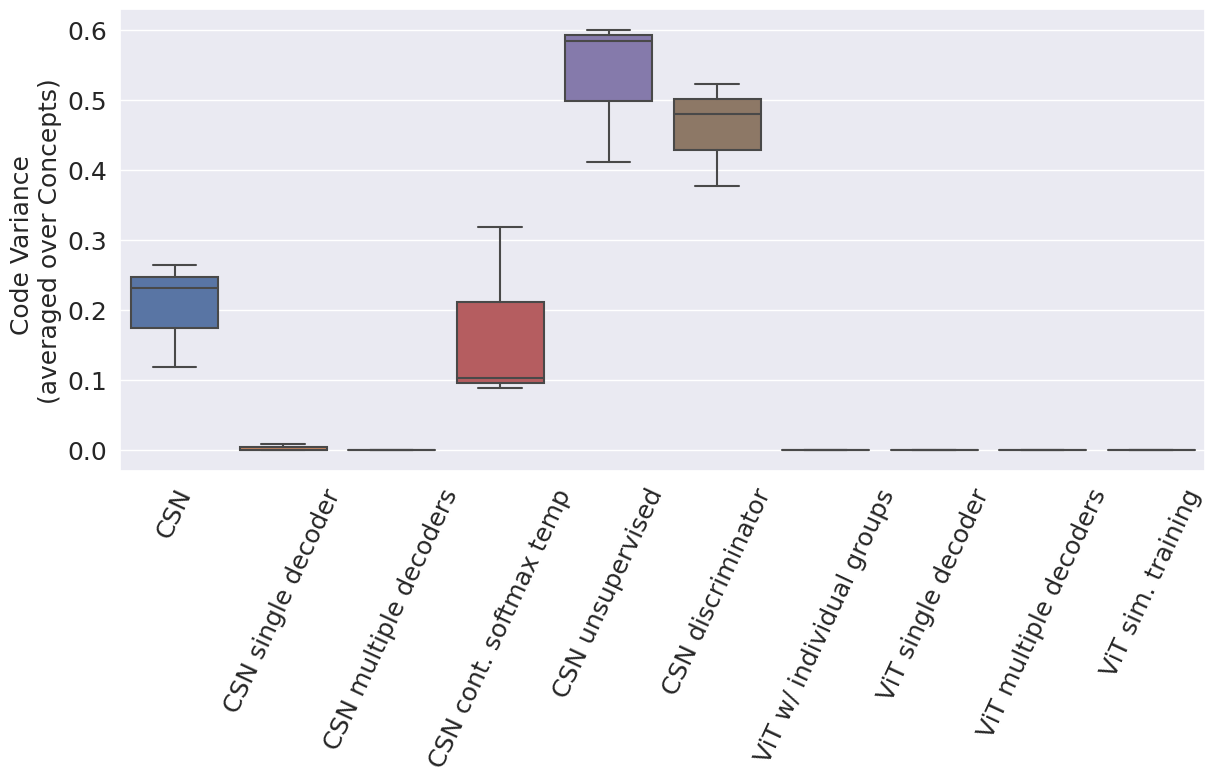

In [27]:
sns.set()
from matplotlib import rc
rc('font',**{'family':'serif','serif':['DejaVu Sans']})
fig, ax = plt.subplots(figsize=(14, 6))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
sns.boxplot(data=[code_vars_icsn_val, code_vars_csn_singledec_val, code_vars_csn_muldec_val, code_vars_csn_continuous_val, code_vars_csn_unsup_val, code_vars_csn_disc_val, code_vars_vt_groups_val, code_vars_vt_singledec_val, code_vars_vt_muldec_val, code_vars_vt_disc_val,
                  ])
ax.set_xticklabels(["CSN", "CSN single decoder", "CSN multiple decoders", "CSN cont. softmax temp", "CSN unsupervised", "CSN discriminator", "ViT w/ individual groups", "ViT single decoder", "ViT multiple decoders", "ViT sim. training", 
                    ], fontsize=18, rotation=65)
ax.set_ylabel("Code Variance \n(averaged over Concepts)", fontsize=18)
# ax.set_title("Average Latent Code Variance", fontsize=26)

fig.savefig("code_variance.pdf", bbox_inches='tight')
plt.show()


